# Food Stamps Application Analysis

Sergio Nieto

_Analysis of the likelihood of appliying for Food Stamps or Supplemental Nutrition Assistance Program (SNAP) using the information from the PUMS datasets._

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qSergio/techy_food/blob/main/Food_census.ipynb)

## Initial Objectives

1. Data too large for the analysis?
2. What is the incidence rate for applications?
3. What data makes sense to use as potential features for a model, and which data does not?
4. What data cleansing techniques are needed?
5. What relevant metrics may be used to determine if a model is acceptable or not? 
6. Is it possible to test the results on another state, like Texas or California

Dataset is not too large, maybe after merging with more states and adding historic census info. There are some options when data is too large for local review of all the dataset:

- Use a Database like postgresql or another to kickoff exploratory analysis.
- If not all data is needed at once, it is possible to use chunks of data only agregating when necessary.
- Sometimes, when you know a priori charactericstics of the dataset you can do: load useful columns only, change datatypes (truncating), use sparse representation if too many null values are to be stored.
- Usually recurring to a cloud provider of a database maybe an option.

## Data-Business Understanding

Taking introductory information from documentation:

The Public Use Microdata Sample (PUMS) are a subset of the 2021 American Community Survey (ACS) and Puerto Rico Community Survey (PRCS) samples.

The Census Bureau takes further steps to prevent the identification of specific individuals, households, or housing units, on the PUMS files. The main disclosure avoidance method used is to limit the geographic detail shown in the files. The smallest geographic unit that is identi- fied is the Public Use Microdata Area (PUMA). The current PUMAs were formed based on data and location collected in the 2010 Census and have been used by the ACS PUMS files since the 2012 data year. They do not cross state boundaries.

There are 2 main datasets by State: Housing unit related and Person related. We refer to them as Housing dataset and Population dataset just for simplicity.

Only Population data was provided. REading the documentation provided it can be found that the Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency variable was available in the Housing units dataset so both will be used in the analysis.

### Supplemental Nutrition Assistance Program (SNAP)

The Supplemental Nutrition Assistance Program (SNAP) is the largest federal nutrition assistance program. SNAP provides benefits to eligible low-income individuals and families via an Electronic Benefits Transfer card. This card can be used like a debit card to purchase eligible food in authorized retail food stores ([ref](https://www.benefits.gov/benefit/361#:~:text=The%20Supplemental%20Nutrition%20Assistance%20Program,in%20authorized%20retail%20food%20stores.)).

To be eligible for SNAP benefits, you must meet your state’s requirements, including income limits. States can also take other resources into account, like the money you have in your bank, to decide if you qualify for SNAP.

### Findings

To Do





False Positives are those housing units that did not applied for a Food Stamp but the model assigns a high likelihood of application.

- Too many of these may imply (for example) that too many resources will be destined to the program at some specific targets and not used.

- An example may be to use a Social Field Service team to visit the housing or to use marketing resources targeting these false positives.

False Negatives are those housing units that did apply for a Food Stamp but the model assigns a low likelihood of application.

- Too many of these may imply (for example) that people in need of assistance may not be aware of the program (resources are used for awareness of the false positives) or that resources may not be available for them (adding constraints in terms of distance or other).

Both of these will depend on the general characteristics of the profile that has a high likelihood of apliying. 

In [1]:
# Start by loading relevant libraries for the analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Processing 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, KFold
from imblearn.over_sampling import SMOTE

# Sklearn models and evaluation
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay, recall_score, roc_auc_score
from sklearn.feature_selection import RFECV

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('psam_p05.csv')

In [3]:
dfh = pd.read_csv('psam_house05.csv')

In [4]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Columns: 241 entries, RT to WGTP80
dtypes: float64(149), int64(90), object(2)
memory usage: 28.0+ MB


In [5]:
dfh.shape, df.shape

((15208, 241), (30050, 287))

In [6]:
dfh.head(3)

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,TYPEHUGQ,ACCESSINET,ACR,AGS,BATH,BDSP,BLD,BROADBND,COMPOTHX,CONP,DIALUP,ELEFP,ELEP,FS,FULFP,FULP,GASFP,GASP,HFL,HISPEED,HOTWAT,INSP,LAPTOP,MHP,MRGI,MRGP,MRGT,MRGX,OTHSVCEX,REFR,RMSP,RNTM,RNTP,RWAT,RWATPR,SATELLITE,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,VACDUR,VACOTH,VACS,VALP,VEH,WATFP,WATP,YRBLT,CPLT,FINCP,FPARC,GRNTP,GRPIP,HHL,HHLANP,HHLDRAGEP,HHLDRHISP,HHLDRRAC1P,HHT,HHT2,HINCP,HUGCL,HUPAC,HUPAOC,HUPARC,KIT,LNGI,MULTG,MV,NOC,NPF,NPP,NR,NRC,OCPIP,PARTNER,PLM,PLMPRP,PSF,R18,R60,R65,RESMODE,SMOCP,SMX,SRNT,SVAL,TAXAMT,WIF,WKEXREL,WORKSTAT,FACCESSP,FACRP,FAGSP,FBATHP,FBDSP,FBLDP,FBROADBNDP,FCOMPOTHXP,FCONP,FDIALUPP,FELEP,FFINCP,FFSP,FFULP,FGASP,FGRNTP,FHFLP,FHINCP,FHISPEEDP,FHOTWATP,FINSP,FKITP,FLAPTOPP,FMHP,FMRGIP,FMRGP,FMRGTP,FMRGXP,FMVP,FOTHSVCEXP,FPLMP,FPLMPRP,FREFRP,FRMSP,FRNTMP,FRNTP,FRWATP,FRWATPRP,FSATELLITEP,FSINKP,FSMARTPHONP,FSMOCP,FSMP,FSMXHP,FSMXSP,FSTOVP,FTABLETP,FTAXP,FTELP,FTENP,FVACDURP,FVACOTHP,FVACSP,FVALP,FVEHP,FWATP,FYRBLTP,WGTP1,WGTP2,WGTP3,WGTP4,WGTP5,WGTP6,WGTP7,WGTP8,WGTP9,WGTP10,WGTP11,WGTP12,WGTP13,WGTP14,WGTP15,WGTP16,WGTP17,WGTP18,WGTP19,WGTP20,WGTP21,WGTP22,WGTP23,WGTP24,WGTP25,WGTP26,WGTP27,WGTP28,WGTP29,WGTP30,WGTP31,WGTP32,WGTP33,WGTP34,WGTP35,WGTP36,WGTP37,WGTP38,WGTP39,WGTP40,WGTP41,WGTP42,WGTP43,WGTP44,WGTP45,WGTP46,WGTP47,WGTP48,WGTP49,WGTP50,WGTP51,WGTP52,WGTP53,WGTP54,WGTP55,WGTP56,WGTP57,WGTP58,WGTP59,WGTP60,WGTP61,WGTP62,WGTP63,WGTP64,WGTP65,WGTP66,WGTP67,WGTP68,WGTP69,WGTP70,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,H,2021GQ0000060,7,700,3,5,1000000,1029928,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H,2021GQ0000334,7,1900,3,5,1000000,1029928,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,H,2021GQ0000904,7,1100,3,5,1000000,1029928,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


A quick look at datasets shows that information has null values, encoded values and needs to be weighted before aggregating.

In the Population dataset we have repeated ids that correspond to different values in the SPORDER variable. This variable encodes the number of person within a house unit, so I'll use only sporder=1 to refer to the first contributor in the housing unit, this is only to simplify analysis.

In [8]:
df[df['SERIALNO']== '2021HU0811808']

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTRNS,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPIK,MLPJ,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RELSHIPP,RETP,SCH,SCHG,SCHL,SEMP,SEX,SSIP,SSP,WAGP,WKHP,WKL,WKWN,WRK,YOEP,ANC,ANC1P,ANC2P,DECADE,DIS,DRIVESP,ESP,ESR,FOD1P,FOD2P,HICOV,HISP,INDP,JWAP,JWDP,LANP,MIGPUMA,MIGSP,MSP,NAICSP,NATIVITY,NOP,OC,OCCP,PAOC,PERNP,PINCP,POBP,POVPIP,POWPUMA,POWSP,PRIVCOV,PUBCOV,QTRBIR,RAC1P,RAC2P,RAC3P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACPI,RACSOR,RACWHT,RC,SCIENGP,SCIENGRLP,SFN,SFR,SOCP,VPS,WAOB,FAGEP,FANCP,FCITP,FCITWP,FCOWP,FDDRSP,FDEARP,FDEYEP,FDISP,FDOUTP,FDPHYP,FDRATP,FDRATXP,FDREMP,FENGP,FESRP,FFERP,FFODP,FGCLP,FGCMP,FGCRP,FHICOVP,FHIMRKSP,FHINS1P,FHINS2P,FHINS3C,FHINS3P,FHINS4C,FHINS4P,FHINS5C,FHINS5P,FHINS6P,FHINS7P,FHISP,FINDP,FINTP,FJWDP,FJWMNP,FJWRIP,FJWTRNSP,FLANP,FLANXP,FMARP,FMARHDP,FMARHMP,FMARHTP,FMARHWP,FMARHYP,FMIGP,FMIGSP,FMILPP,FMILSP,FOCCP,FOIP,FPAP,FPERNP,FPINCP,FPOBP,FPOWSP,FPRIVCOVP,FPUBCOVP,FRACP,FRELSHIPP,FRETP,FSCHGP,FSCHLP,FSCHP,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWNP,FWRKP,FYOEP,PWGTP1,PWGTP2,PWGTP3,PWGTP4,PWGTP5,PWGTP6,PWGTP7,PWGTP8,PWGTP9,PWGTP10,PWGTP11,PWGTP12,PWGTP13,PWGTP14,PWGTP15,PWGTP16,PWGTP17,PWGTP18,PWGTP19,PWGTP20,PWGTP21,PWGTP22,PWGTP23,PWGTP24,PWGTP25,PWGTP26,PWGTP27,PWGTP28,PWGTP29,PWGTP30,PWGTP31,PWGTP32,PWGTP33,PWGTP34,PWGTP35,PWGTP36,PWGTP37,PWGTP38,PWGTP39,PWGTP40,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
17706,P,2021HU0811808,7,1,100,3,5,1029928,57,52,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0,0,1,2,2,2,2,2,2,30.0,NaN,NaN,11.0,2.0,2,2.0,2.0,1.0,1.0,1992.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.0,3.0,0.0,0.0,20,0.0,1.0,NaN,22.0,20000.0,1,0.0,0.0,135000.0,48.0,1.0,52.0,1.0,NaN,2,22,32,NaN,2,NaN,NaN,1.0,6200.0,6201.0,1,1,6695.0,NaN,NaN,NaN,NaN,NaN,3.0,5182,1,NaN,0.0,110.0,NaN,155000.0,155030.0,49,497.0,100.0,5.0,1,2,4,1,1,1,0,0,0,0,1,0,0,1,0.0,2.0,2.0,NaN,NaN,113021,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57,51,22,93,56,104,90,50,90,19,65,54,60,16,53,88,52,19,18,70,65,64,16,101,62,89,92,57,87,15,61,65,62,17,56,84,56,18,16,50,65,61,19,96,57,105,102,49,105,16,53,51,56,18,64,97,55,15,17,60,52,52,18,100,52,98,93,72,104,20,61,58,68,15,50,95,53,21,15,59
17707,P,2021HU0811808,7,2,100,3,5,1029928,90,22,1,NaN,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,1,2.0,2.0,1.0,2.0,2017.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,2.0,3.0,0.0,0.0,25,0.0,1.0,NaN,19.0,0.0,2,0.0,0.0,0.0,NaN,3.0,NaN,2.0,NaN,2,22,32,NaN,2,NaN,NaN,6.0,NaN,NaN,1,1,NaN,NaN,NaN,NaN,100.0,5.0,1.0,NaN,1,NaN,0.0,NaN,1.0,0.0,0.0,49,497.0,NaN,NaN,1,2,4,1,1,1,0,0,0,0,1,0,0,1,0.0,NaN,NaN,1.0,2.0,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,124,101,22,155,75,129,155,112,155,30,79,93,103,28,90,129,67,25,27,97,110,107,26,164,105,150,128,104,160,29,74,87,104,28,105,155,72,26,26,99,139,90,27,173,84,131,162,93,171,26,95,83,88,28,93,132,88,26,25,107,83,82,30,178,85,131,138,113,166,24,97,100,92,22,86,165,94,24,22,89
17708,P,2021HU0811808,7,3,100,3,5,1029928,81,17,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,2.0,3.0,3.0,0.0,0.0,25,0.0,3.0,15.0,17.0,0.0,1,0.0,0.0,3000.0,20.0,1.0,8.0,2.0,NaN,2,22,32,NaN

In [7]:
df = df[df['SPORDER'] ==1].reset_index(drop=True)

### Food Stamp incidence rate

It's possible to calculate incidence rate for recepiency of SNAP. According to documentation, the variable is called FS and FS=1 are those housing units that receive the benefits of the program (there are null values meaning the application is vacant).

> We have 10.77% of the housing units receive the benefits.

In [8]:
dfh.loc[dfh['FS']==2, 'FS'] = 0

# No need to do this...

In [9]:
dfh['FS'].value_counts(normalize=True).mul(100).round(2).astype('str')+'%'

0.0    89.23%
1.0    10.77%
Name: FS, dtype: object

In [10]:
# Removing from the Housing dataset those units without FS value.

dfh = dfh[~dfh['FS'].isnull()].reset_index(drop=True)

## Data Preprocessing

In [13]:
# We need to know if there are shared ids:

dfh['SERIALNO'].isin(df['SERIALNO']).sum(), df['SERIALNO'].isin(dfh['SERIALNO']).sum()

(13615, 13615)

Understanding the datasets variables is crucial for reducing the number of variables before looking into correlations.

- Droping RT, Division, Region, ST because we have the PUMA.

__Note:__ We start by reviewing some of the variables. This process is long and requires more knowledge of the survey process, so in this case only somre variables will be reviewed with care and others will be used without taking into account their meaning relevant to the survey.

### RECORD-HOUSING UNIT VARIABLES 

Some housing variables are binary and related to availability of certain characteristics of the house like internet or water mgmt.

I'll keep almost all variables, droping only those that may imply same capabilities for the household in the unit. 

For example, DIALUP is related to a Dial-up service access to internet in the region, so it may not be a good explicative variable because in other states will change just because geography and different infrastructure. It may be better to use internet access only or a varible related to the usage of internet, like a home business.

In [11]:
dfh['DIALUP'].value_counts()

2.0    10066
1.0      288
Name: DIALUP, dtype: int64

In [12]:
dfh.groupby(['DIALUP'])['FS'].sum().reset_index().sort_values('FS', ascending=False)

,DIALUP,FS
1,2.0,1057.0
0,1.0,24.0


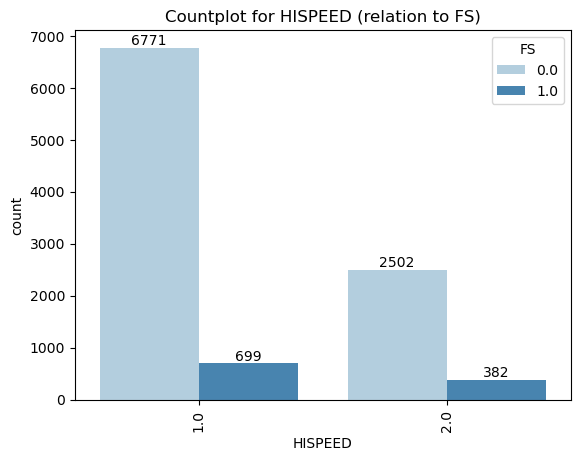

In [13]:
# A variable related to internet but more related to income possibilities is HISPEED

# Broadband (high speed) Internet service such as cable, fiber optic, or  DSL service. 

# HISPEED=1 means the housing unit has acces to this service.

p = 'Blues'

ax = sns.countplot(data=dfh, 
                   x='HISPEED',
                   hue="FS", 
                   palette=p, 
                   order=dfh['HISPEED'].value_counts().index)
ax.set_title('Countplot for HISPEED (relation to FS)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for container in ax.containers:
    ax.bar_label(container)

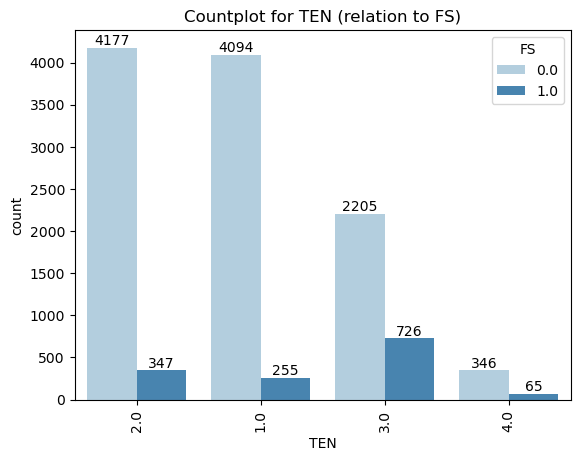

In [14]:
# Just to show another categorical variable, let's see TEN

# Tenure or how persons related to the housing are living 

# b .N/A (GQ/vacant) 
# 1 .Owned with mortgage or loan (include home equity loans) 
# 2 .Owned free and clear 
# 3 .Rented 
# 4 .Occupied without payment of rent


ax = sns.countplot(data=dfh, 
                   x='TEN',
                   hue="FS", 
                   palette=p, 
                   order=dfh['TEN'].value_counts().index)
ax.set_title('Countplot for TEN (relation to FS)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for container in ax.containers:
    ax.bar_label(container)

# We can see that for owned housing, less than 10% apply for a Food stamp,

# but for rented and occupied the proportion increase to more than 20%

### RECORD-HOUSEHOLD VARIABLES 

This variales include income and family characteristics that may become relevant for the analysis. Some of them will be droped like race related (to avoid bias in the possible model) but I'll keep one language variable to account for a possible relationship.

Theres is also the problem of weighting the values like income according to the size of the sample in the survey. According to documentation:

_Each housing and person record is assigned a weight, because the records in the PUMS files represent a sam- ple of the population. The weight is a numeric variable expressing the number of housing units or people that an individual microdata record represents. The sum of the housing unit and person weights for a geographic area is equal to the estimate of the total number of housing units and people in that area. To generate estimates based on the PUMS records, data users must correctly apply weights._

_When working with a merged file that includes both housing and person records, person weights should be used to produce estimates for person characteristics..._

_There are two additional sets of weights, one for households ranging from WGTP1 to WGTP80, and one for individuals ranging from PWGTP1 to PWGTP80. These “replicate weights” are used to calculate the error associated with each estimate. For more informa- tion about replicate weights, see the section below on “Data Quality in the ACS PUMS.”
TIP: To generate statistics for housing units or house- holds (for example, data on average household income), data users should apply the PUMS household weights (WGTP). To generate statistics for individuals (such as age or educational attainment), data users should apply the PUMS person weights (PWGTP)._

I'll drop WGTP and PWGTP since they're related to error analysis.

In [15]:
pwgt_cols = list(df.columns)
hwgt_cols = list(dfh.columns)

In [16]:
p_to_drop = [x for x in pwgt_cols if ('WGTP' in x)]
h_to_drop = [x for x in hwgt_cols if ('WGTP' in x)]

In [17]:
# Only keeping the first member of the list
p_to_drop.remove('PWGTP')
h_to_drop.remove('WGTP')
p_to_drop[:3], h_to_drop[:3]

(['PWGTP1', 'PWGTP2', 'PWGTP3'], ['WGTP1', 'WGTP2', 'WGTP3'])

In [18]:
# Add unused variables in each case, population and housing:

np_to_drop = ['RT', 'DIVISION', 'SPORDER', 'PUMA', 'REGION' , 'ST', 'AGEP', 'CIT', 'CITWP',
              # Drop all PERSON RECORD-RECODED PERSON VARIABLES to simplify and maybe avoid duplicate info
              'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR',
       'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP',
       'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 
              'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP',
       'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RAC2P', 'RAC3P', 'RACAIAN',
       'RACASN', 'RACBLK', 'RACNH', 'RACNUM', 'RACPI', 'RACSOR', 'RACWHT',
       'RC', 'SCIENGP', 'SCIENGRLP', 'SFN', 'SFR', 'SOCP', 'VPS', 'WAOB',
       'FAGEP', 'FANCP', 'FCITP', 'FCITWP', 'FCOWP', 'FDDRSP', 'FDEARP',
       'FDEYEP', 'FDISP', 'FDOUTP', 'FDPHYP', 'FDRATP', 'FDRATXP', 'FDREMP',
       'FENGP', 'FESRP', 'FFERP', 'FFODP', 'FGCLP', 'FGCMP', 'FGCRP', 'FHICOVP', 
              'FHIMRKSP', 'FHINS1P', 'FHINS2P', 'FHINS3C',
       'FHINS3P', 'FHINS4C', 'FHINS4P', 'FHINS5C', 'FHINS5P', 'FHINS6P',
       'FHINS7P', 'FHISP', 'FINDP', 'FINTP', 'FJWDP', 'FJWMNP', 'FJWRIP',
       'FJWTRNSP', 'FLANP', 'FLANXP', 'FMARP', 'FMARHDP', 'FMARHMP', 'FMARHTP',
       'FMARHWP', 'FMARHYP', 'FMIGP', 'FMIGSP', 'FMILPP', 'FMILSP', 'FOCCP',
       'FOIP', 'FPAP', 'FPERNP', 'FPINCP', 'FPOBP', 'FPOWSP', 'FPRIVCOVP',
       'FPUBCOVP', 'FRACP', 'FRELSHIPP', 'FRETP', 'FSCHGP', 'FSCHLP', 'FSCHP',
       'FSEMP', 'FSEXP', 'FSSIP', 'FSSP', 'FWAGP', 'FWKHP', 'FWKLP', 'FWKWNP',
       'FWRKP', 'FYOEP'] + p_to_drop

nh_to_drop = ['RT', 'DIVISION', 'REGION' , 'ST' ] + h_to_drop

In [19]:
df.drop(columns = np_to_drop, inplace=True)
dfh.drop(columns = nh_to_drop, inplace=True)

In [20]:
dfh.columns[:12]

Index(['SERIALNO', 'PUMA', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'TYPEHUGQ',
       'ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP'],
      dtype='object')

In [21]:
df.columns

Index(['SERIALNO', 'ADJINC', 'PWGTP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT',
       'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR',
       'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7',
       'INTP', 'JWMNP', 'JWRIP', 'JWTRNS', 'LANX', 'MAR', 'MARHD', 'MARHM',
       'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPCD',
       'MLPE', 'MLPFG', 'MLPH', 'MLPIK', 'MLPJ', 'NWAB', 'NWAV', 'NWLA',
       'NWLK', 'NWRE', 'OIP', 'PAP', 'RELSHIPP', 'RETP', 'SCH', 'SCHG', 'SCHL',
       'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN', 'WRK',
       'YOEP'],
      dtype='object')

Now, we try a left join from Population data to the Housing dataset

In [28]:
dfh.shape, df.shape

((13615, 157), (13615, 68))

In [22]:
# The new merged dataframe will be called pums, after merging we can use the id SERIALNO as index

# 

pums = pd.merge(dfh, df, on="SERIALNO", how="left")
pums.shape

(13615, 224)

In [23]:
pums.set_index('SERIALNO', inplace=True)
pums.drop(columns=['ADJINC_x','ADJINC_y','ADJHSG'],inplace=True) # We do not need adjusment values for this analysis

In [24]:
pums['PWGTP'].describe()

count    13615.000000
mean        92.506133
std         86.362092
min          1.000000
25%         38.000000
50%         70.000000
75%        113.000000
max       1617.000000
Name: PWGTP, dtype: float64

In [25]:
pums['WGTP'].describe()

count    13615.000000
mean        86.939038
std         89.517480
min          0.000000
25%         29.000000
50%         64.000000
75%        112.000000
max       1616.000000
Name: WGTP, dtype: float64

In [26]:
pums.head() #ADJINC_y = 1029928

,PUMA,WGTP,NP,TYPEHUGQ,ACCESSINET,ACR,AGS,BATH,BDSP,BLD,BROADBND,COMPOTHX,CONP,DIALUP,ELEFP,ELEP,FS,FULFP,FULP,GASFP,GASP,HFL,HISPEED,HOTWAT,INSP,LAPTOP,MHP,MRGI,MRGP,MRGT,MRGX,OTHSVCEX,REFR,RMSP,RNTM,RNTP,RWAT,RWATPR,SATELLITE,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,VACDUR,VACOTH,VACS,VALP,VEH,WATFP,WATP,YRBLT,CPLT,FINCP,FPARC,GRNTP,GRPIP,HHL,HHLANP,HHLDRAGEP,HHLDRHISP,HHLDRRAC1P,HHT,HHT2,HINCP,HUGCL,HUPAC,HUPAOC,HUPARC,KIT,LNGI,MULTG,MV,NOC,NPF,NPP,NR,NRC,OCPIP,PARTNER,PLM,PLMPRP,PSF,R18,R60,R65,RESMODE,SMOCP,SMX,SRNT,SVAL,TAXAMT,WIF,WKEXREL,WORKSTAT,FACCESSP,FACRP,FAGSP,FBATHP,FBDSP,FBLDP,FBROADBNDP,FCOMPOTHXP,FCONP,FDIALUPP,FELEP,FFINCP,FFSP,FFULP,FGASP,FGRNTP,FHFLP,FHINCP,FHISPEEDP,FHOTWATP,FINSP,FKITP,FLAPTOPP,FMHP,FMRGIP,FMRGP,FMRGTP,FMRGXP,FMVP,FOTHSVCEXP,FPLMP,FPLMPRP,FREFRP,FRMSP,FRNTMP,FRNTP,FRWATP,FRWATPRP,FSATELLITEP,FSINKP,FSMARTPHONP,FSMOCP,FSMP,FSMXHP,FSMXSP,FSTOVP,FTABLETP,FTAXP,FTELP,FTENP,FVACDURP,FVACOTHP,FVACSP,FVALP,FVEHP,FWATP,FYRBLTP,PWGTP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTRNS,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPIK,MLPJ,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RELSHIPP,RETP,SCH,SCHG,SCHL,SEMP,SEX,SSIP,SSP,WAGP,WKHP,WKL,WKWN,WRK,YOEP
SERIALNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021GQ0000060,700,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,0,2,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.0,3.0,0.0,0.0,37,0.0,1.0,NaN,17.0,0.0,1,0.0,0.0,0.0,NaN,3.0,NaN,NaN,NaN
2021GQ0000334,1900,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,2.0,3.0,0.0,0.0,38,0.0,2.0,15.0,19.0,0.0,1,0.0,0.0,0.0,NaN,3.0,NaN,2.0,NaN
2021GQ0000904,1100,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,1.0,2,2,1.0,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0,2,2,1,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,

In [27]:
total_nan=pums.isnull().sum(axis = 0)
#total_nan
total_nan=total_nan.sort_values(ascending=False)

total_nan.head(26)

VACDUR    13615
VACS      13615
VACOTH    13615
GCM       13352
SMP       13309
GCR       13184
DRAT      13174
YOEP      12969
ENG       12889
FULP      12776
SCHG      12714
MHP       12592
MLPA      12162
MLPB      12162
MLPCD     12162
MLPE      12162
MLPFG     12162
MLPH      12162
MLPIK     12162
MLPJ      12162
DRATX     11863
GRPIP     10765
RNTM      10684
GRNTP     10684
RNTP      10684
FER       10679
dtype: int64

We're not done yet. Some variables are numeric but they are encoding information so they must be treated as categorical. Also, we need to assign the NA to a category in those cases. 

- Numerical variables are either encoded strings or floats.
- Total data records are 13615, so only those variable with more than 75% (10,211) of null values will be analized, meaning that NaN values will be reviwed and maybe assigned to a specific category.
- Below that number all NaN values will be assigned to a category.

Decisions: 

1. VACDUR, VACOTH, VACS (Vacancy duration, status, other status) they have full NaN values so we do not need them, no variability. 
2. SMP (Total payment on all second and junior mortgages and home equity loans ) will be droped since we have the flag variable equivalent.
3. GCR, GCM (Grandparents responsible for grandchildren) maybe relevant in other states so it will be droped to avoid bias to low presence of the variables. We have GCL to account for it.
4. DRAT (Veteran service-connected disability rating) will be droped, DRATX has less null values and meaning assigned.
5. YOEP (Year of entry) means year of entry, NAN means born in the us. Variable droped since small variability.
6. ENG (Ability to speak English) will be kept.
7. FULP (Fuel cost) dropped since we have FULFP.
8. SCHG (Grade level attending) dropped since we have SCH (school enrollment).
9. MHP (Mobile home costs) dropped.
10. MLPJ, MLPA, MLPIK, MLPB, MLPCD,MLPE,MLPFG, MLPH (military service related) dropped since MIL is used.
11. GRPIP (Gross rent as a percentage of household income past 12 months) will be used, NaN set to zero
12. FGRNTP (Gross rent (monthly amount) allocation flag) is used, so RNTP, RNTM, FRNTP, GRNTP will be dropped.

In [37]:
pums.groupby(['FGRNTP'])['FS'].sum().reset_index().sort_values('FS', ascending=False)

,FGRNTP,FS
0,0.0,1235.0
1,1.0,158.0


In [38]:
pums['GRPIP'].describe()

count    2850.000000
mean       36.334035
std        26.358039
min         1.000000
25%        18.000000
50%        28.000000
75%        45.000000
max       101.000000
Name: GRPIP, dtype: float64

In [28]:
dropped_nan = ['VACDUR', 'VACOTH', 'VACS', 'SMP' , 'GCR', 
               'GCM','DRAT' ,'YOEP','FULP' ,'SCHG','MHP', 'MLPJ', 'MLPA', 
               'MLPIK', 'MLPB', 'MLPCD','MLPE','MLPFG', 'MLPH', 'RNTP', 
               'RNTM', 'FRNTP', 'GRNTP']

In [29]:
pums.drop(columns=dropped_nan, inplace=True)

In [30]:
# This columns do not have any null values

list_ints_cols = pums.select_dtypes(include=['int']).columns
list_ints_cols

Index(['PUMA', 'WGTP', 'NP', 'TYPEHUGQ', 'FFSP', 'PWGTP', 'DEAR', 'DEYE',
       'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7',
       'MAR', 'RELSHIPP', 'SEX'],
      dtype='object')

In [31]:
for col in list_ints_cols:
    pums[col] = pums[col].astype('Int64')

In [32]:
# Some columns have the value zero for all rows, so they'll be droped.

pums.drop(columns = ['FHOTWATP', 'FPLMPRP', 'FRWATPRP', 'FVACDURP', 'FVACOTHP', 'FVACSP'], 
        inplace=True)

In [33]:
# The rest of the variables have null values

list_floats_cols = pums.select_dtypes(include=[ 'float64']).columns
list_floats_cols

Index(['ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP', 'BLD', 'BROADBND',
       'COMPOTHX', 'CONP', 'DIALUP',
       ...
       'SCH', 'SCHL', 'SEMP', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN',
       'WRK'],
      dtype='object', length=172)

In [34]:
pums[list_floats_cols].describe()

,ACCESSINET,ACR,AGS,BATH,BDSP,BLD,BROADBND,COMPOTHX,CONP,DIALUP,ELEFP,ELEP,FS,FULFP,GASFP,GASP,HFL,HISPEED,HOTWAT,INSP,LAPTOP,MRGI,MRGP,MRGT,MRGX,OTHSVCEX,REFR,RMSP,RWAT,RWATPR,SATELLITE,SINK,SMARTPHONE,STOV,TABLET,TEL,TEN,VALP,VEH,WATFP,WATP,YRBLT,CPLT,FINCP,FPARC,GRPIP,HHL,HHLANP,HHLDRAGEP,HHLDRHISP,HHLDRRAC1P,HHT,HHT2,HINCP,HUGCL,HUPAC,HUPAOC,HUPARC,KIT,LNGI,MULTG,MV,NOC,NPF,NPP,NR,NRC,OCPIP,PARTNER,PLM,PLMPRP,PSF,R18,R60,R65,RESMODE,SMOCP,SMX,SRNT,SVAL,TAXAMT,WIF,WKEXREL,WORKSTAT,FACCESSP,FACRP,FAGSP,FBATHP,FBDSP,FBLDP,FBROADBNDP,FCOMPOTHXP,FCONP,FDIALUPP,FELEP,FFINCP,FFULP,FGASP,FGRNTP,FHFLP,FHINCP,FHISPEEDP,FINSP,FKITP,FLAPTOPP,FMHP,FMRGIP,FMRGP,FMRGTP,FMRGXP,FMVP,FOTHSVCEXP,FPLMP,FREFRP,FRMSP,FRNTMP,FRWATP,FSATELLITEP,FSINKP,FSMARTPHONP,FSMOCP,FSMP,FSMXHP,FSMXSP,FSTOVP,FTABLETP,FTAXP,FTELP,FTENP,FVALP,FVEHP,FWATP,FYRBLTP,COW,DDRS,DOUT,DPHY,DRATX,DREM,ENG,FER,GCL,INTP,JWMNP,JWRIP,JWTRNS,LANX,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RETP,SCH,SCHL,SEMP,SSIP,SSP,WAGP,WKHP,WKL,WKWN,WRK
count,12215.000000,10771.000000,4335.000000,12215.000000,12215.000000,12215.000000,10354.000000,12215.000000,8873.000000,10354.000000,12215.000000,11858.000000,13615.000000,12215.000000,12215.000000,6868.000000,12215.000000,10354.000000,12215.0,8873.000000,12215.000000,4274.000000,12215.000000,4274.000000,8873.000000,10354.000000,12215.000000,12215.000000,12215.000000,12215.0,10354.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8.873000e+03,12215.000000,12215.000000,10474.000000,12215.000000,6765.000000,8.062000e+03,8062.000000,2850.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,1.221500e+04,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8062.000000,12215.000000,12215.000000,12215.000000,8781.000000,12215.000000,12215.000000,12215.0,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8873.000000,4349.000000,12215.000000,12215.000000,8873.000000,8062.000000,8062.000000,8020.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8805.000000,13615.000000,13610.000000,13615.000000,1752.000000,13615.000000,726.000000,2936.000000,11884.000000,13610.000000,5812.000000,5606.000000,6520.000000,13615.000000,10917.000000,10917.000000,10917.000000,10917.000000,10917.000000,13615.000000,13606.000000,13609.000000,13609.000000,13609.000000,13609.000000,13609.000000,13610.000000,13610.000000,13610.000000,13615.000000,13615.000000,13610.000000,13610.000000,13610.000000,13610.000000,7337.00000,13609.000000,7337.000000,11712.000000
mean,1.281948,1.495590,1.199539,1.002620,2.805813,2.391813,1.084219,1.984282,2.167249,1.972185,2.953909,167.065272,0.107749,2.066230,3.531396,83.469423,2.295375,1.278540,9.0,1006.397836,1.300450,1.291998,326.587966,1.265793,2.048462,1.988121,1.003357,5.998199,1.004339,9.0,1.886131,1.002538,1.144413,1.008514,1.451985,1.009169,1.951208,1.861089e+05,1.928694,2.800491,531.426198,1979.182481,1.209608,8.377329e+04,3.202927,36.334035,1.111011,8955.991158,55.368072,1.203193,1.924683,2.731068,4.218747,6.965689e+04,0.042734,3.457716,3.542284,3.467131,1.009906,1.010725,1.033647,4.173393,0.431027,2.877822,0.012116,0.089889,0.496439,19.867327,0.168318,1.004912,9.0,0.026770,0.271388,0.699468,0.524847,2.266803,834.220219,2.922971,0.268113,0.574703,1106.857883,1.304763,6.74

In [35]:
water_drop = [x for x in list_floats_cols if ('WATP' in x)]
water_drop

['RWATPR', 'WATP', 'FRWATP', 'FWATP']

In [36]:
water_drop.remove('WATP')
water_drop = water_drop + ['HHLANP']

In [37]:
pums.drop(columns = water_drop, 
        inplace=True)

#### Distribution of the float variables

From documentation we know that there are only a few columns that are really float variables:

1. CONP Condominium fee
2. ELEP electricity cost
3. GASP gas cost
4. INSP Fire/hazard/flood insurance
5. MRGP  First mortgage payment
6. WATP water cost (all related variables were dropped)
7. FINCP family income
8. GRPIP Gross rent as a percentage of household income past 12 months
9. HHLANP detailed lang, dropped
10. HHLDRAGEP Age of the householder 
11. HINCP  Household income
12. OCPIP Selected monthly owner costs as a percentage of household income during  the past 12 months
13. SMOCP Selected monthly owner costs
14. TAXAMT Property taxes 
15. OIP All other income past 12 months
16. PAP Public assistance income past 12 months
17. RETP Retirement income past 12 months
18. SEMP Self-employment income past 12 months
19. SSIP Supplementary Security Income past 12 months
20. SSP Social Security income past 12 months
21. WAGP Wages or salary income past 12 months 
22. WKHP Usual hours worked per week past 12 months

In [38]:
true_floats =  ['WGTP','PWGTP', 'CONP', 'ELEP', 'GASP', 'INSP', 'MRGP', 
                'WATP', 'FINCP', 'GRPIP', 'HHLDRAGEP', 'HINCP', 
                'OCPIP', 'SMOCP', 'TAXAMT', 'OIP', 'PAP', 'RETP', 
                'SEMP', 'SSIP', 'SSP', 'WAGP', 'WKHP']

In [39]:
pums['WGTP'] = pums['WGTP'].astype('float64')
pums['PWGTP'] = pums['PWGTP'].astype('float64')

Text(0.5, 0.98, 'Distribution')

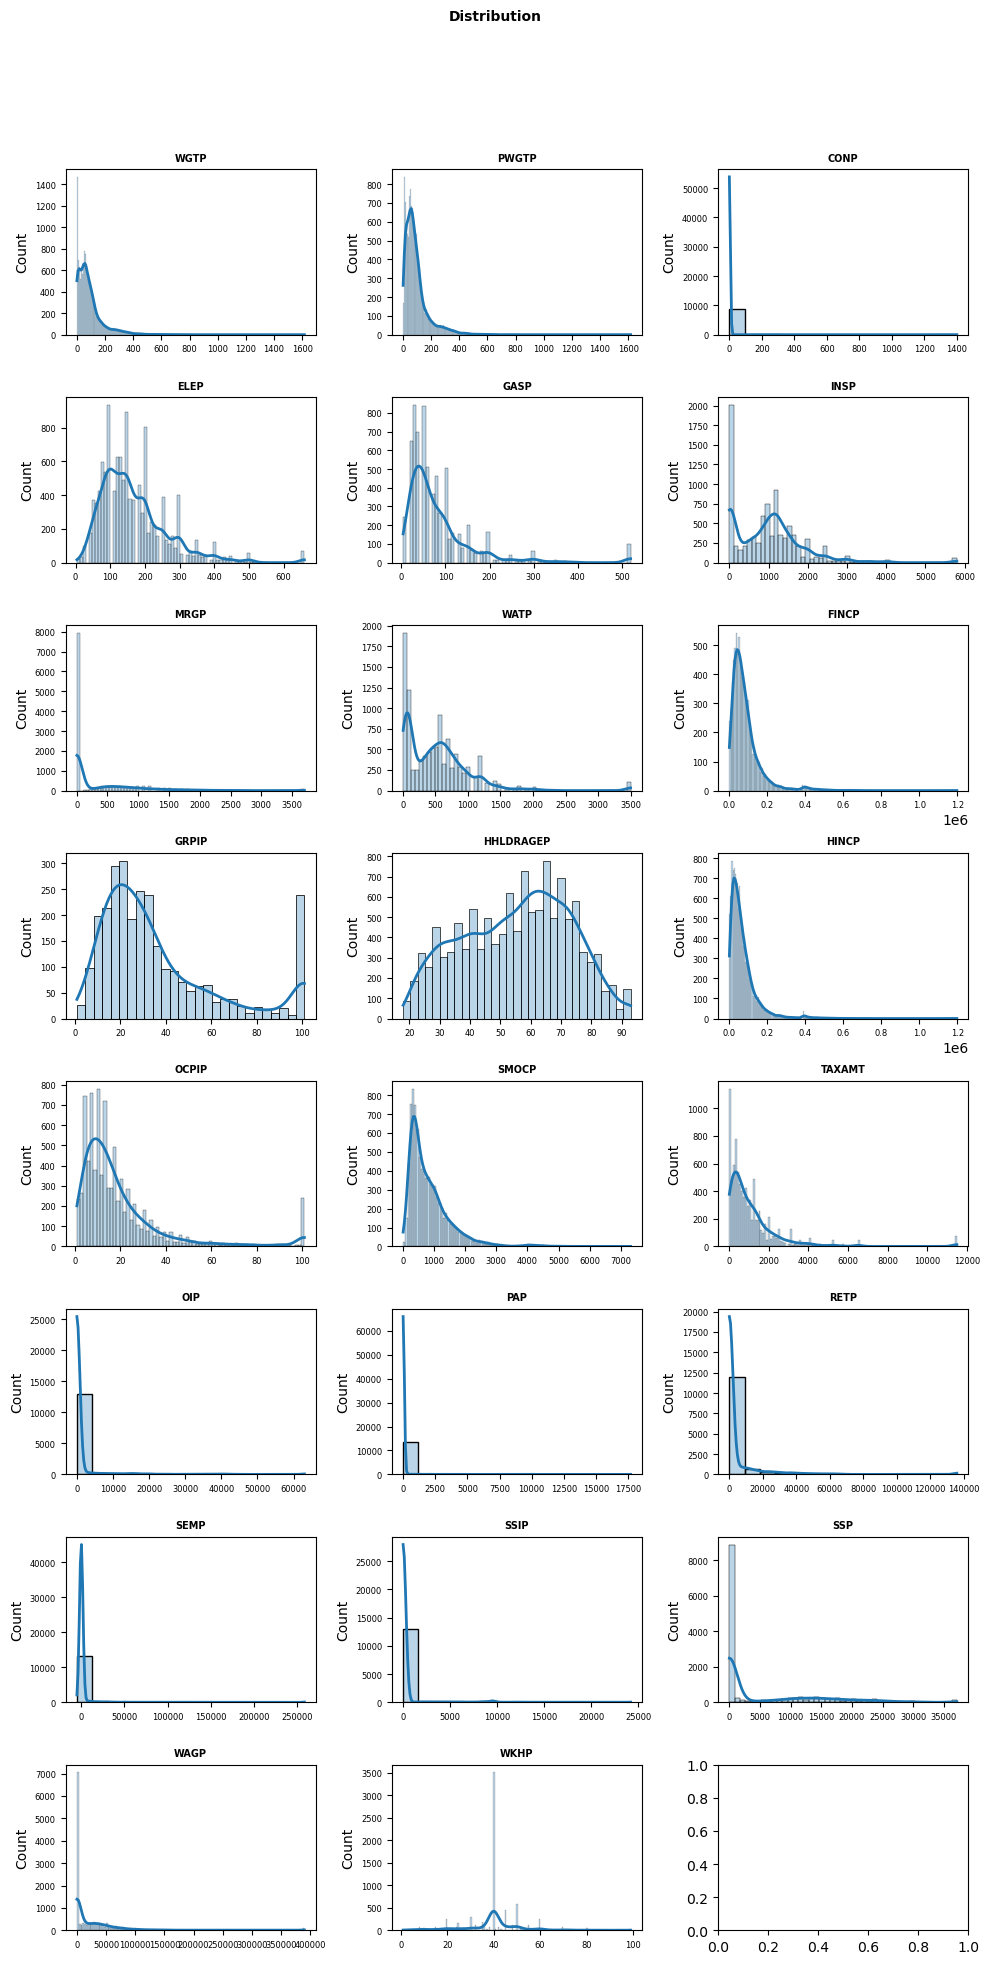

In [40]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10,20))
axes = axes.flat
for i, colum in enumerate(true_floats):
    sns.histplot(
        data    = pums,
        x       = colum,
        stat    = "count",
        kde     = True,
        #color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribution', fontsize = 10, fontweight = "bold")

In [50]:
pums['SSP'].describe()

count    13610.000000
mean      5157.239530
std       8400.216465
min          0.000000
25%          0.000000
50%          0.000000
75%      10400.000000
max      37100.000000
Name: SSP, dtype: float64

> Variables imputed with mean:
> WKHP, HHLDRAGEP, ELEP

> The rest will be imputed with the median to avoid long tailed effects on mean.

__Note__: before truly imputing there's a need to separate the pums dataframe into train-dev sets to avoid data leakage (the train set will "know" information about the test set).

* _The data frame "data" will be used for model selection/training/testing and keeping "pums" data frame for visualization._

In [41]:
target_name = "FS"
target = pums[target_name]
data = pums.drop(columns=[target_name])

In [42]:
# Note we keep using pums

for x in ['WKHP', 'HHLDRAGEP', 'ELEP']:
    pums.loc[pums[x].isnull(),x] = pums[x].mean()

In [43]:
for x in [col for col in true_floats if col not in ['WKHP', 'HHLDRAGEP', 'ELEP']]:
    pums.loc[pums[x].isnull(),x] = pums[x].median()

<Axes: >

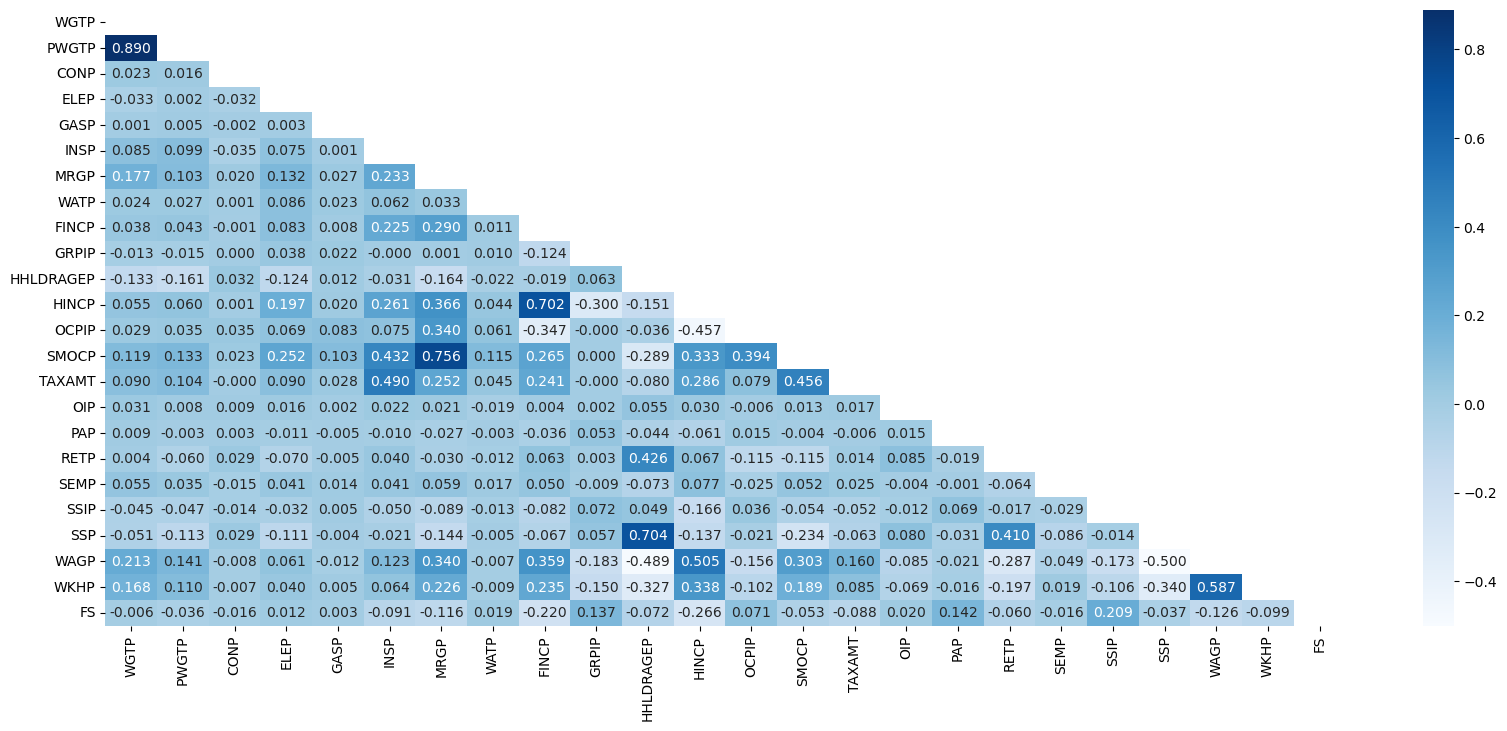

In [44]:
plt.figure(figsize=(20,8))
corr_matrix = pums[true_floats+['FS']].corr('spearman')
sns.heatmap(corr_matrix, 
            cbar=True, 
            annot=True,  
            mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), 
            fmt='.3f', cmap=p)

* All correlations between FS and the numerical variables are small so we do not need to eliminate variables based on this criterion.
* Another step we could take is to average highly correlated variables, but we can wait to do that after if model selection fails to perform well.
* In the meantime, I'l just remove PWGTP-Population weight, keeping the weight associated to Housing, and SMOCP Selected monthly owner costs, keep MRGP-First mortgage payment.

In [ ]:
pums.drop(columns=['PWGTP', 'SMOCP'], inplace=True)

#### Categorical Variables

For the rest of the variables the strategy is to re-encode to avoid dealing with the "0" category in different cases.

In [45]:
pums.dtypes.value_counts()

float64    170
Int64       17
dtype: int64

In [46]:
pums[true_floats].head()

,WGTP,PWGTP,CONP,ELEP,GASP,INSP,MRGP,WATP,FINCP,GRPIP,HHLDRAGEP,HINCP,OCPIP,SMOCP,TAXAMT,OIP,PAP,RETP,SEMP,SSIP,SSP,WAGP,WKHP
SERIALNO,,,,,,,,,,,,,,,,,,,,,,,
2021GQ0000060,0.0,58.0,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128
2021GQ0000334,0.0,106.0,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128
2021GQ0000904,0.0,13.0,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128
2021GQ0001018,0.0,19.0,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,27000.0,99.00000
2021GQ0001134,0.0,68.0,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128


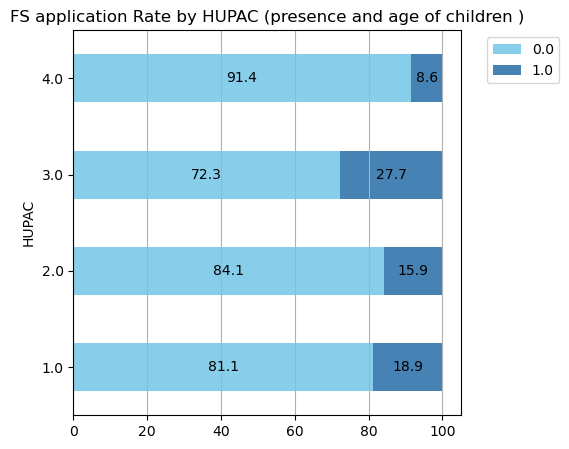

In [48]:
c = ['skyblue', 'steelblue']
df1 = pums.groupby(['HUPAC', 'FS']).size().unstack()
ax = df1.apply(lambda x : round((x/x.sum()*100),1), axis=1).plot(kind='barh', stacked=True, color=c, figsize=(5,5))
plt.title('FS application Rate by HUPAC (presence and age of children )')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='x')
for container in ax.containers:
    ax.bar_label(container, label_type='center')
    
#N/A (GQ/vacant) 
#1 .With children under 6 years only 
#2 .With children 6 to 17 years only 
#3 .With children under 6 years and 6 to 17 years 
#4 .No children 

## Training setup

X_train, X_test, Y_train, Y_test are the relevant sets for this steps but we need to define the column sets to be used first.

In [49]:
#data = pums.drop(columns=[target_name])

#First of all, the float variables not all are numeric, some are flags and thus ordinal fields.

data.dtypes.value_counts()

float64    169
Int64       17
dtype: int64

In [50]:
list_floats_cols = data.select_dtypes(include=[ 'float64']).columns
list_floats_cols[:5]

Index(['WGTP', 'ACCESSINET', 'ACR', 'AGS', 'BATH'], dtype='object')

In [51]:
# I'll use the true_floats list created before to filter floats:

ord_cols = [col for col in list_floats_cols if col not in true_floats]

In [52]:
# All ordinal columns will be set to int64 to be able to manage easily.

for x in ord_cols:
    data[x] = data[x].astype('Int64')

In [53]:
# This one escaped from the initial review... valp is Property value

data['VALP'] = data['VALP'].astype('float64')

In [54]:
data.dtypes.value_counts()

Int64      162
float64     24
dtype: int64

In [55]:
len(true_floats)

23

In [56]:
# The final list of columns will be used later when dealing with the ints as categorical variables.

int_features = data.select_dtypes(include="Int64").columns
num_features = data.select_dtypes(include="float64").columns

In [58]:
num_features

Index(['WGTP', 'CONP', 'ELEP', 'GASP', 'INSP', 'MRGP', 'VALP', 'WATP', 'FINCP',
       'GRPIP', 'HHLDRAGEP', 'HINCP', 'OCPIP', 'SMOCP', 'TAXAMT', 'PWGTP',
       'OIP', 'PAP', 'RETP', 'SEMP', 'SSIP', 'SSP', 'WAGP', 'WKHP'],
      dtype='object')

Train-test split is relevant to understand overfitting of a model at generalization time.

1. I'll use 20% for dev testing.
2. The library _imblearn_ provides useful functions to deal with imbalanced datasets. It's used to upsample the minority class: current FS applciation.
3. SMOTE = Synthetic Minority Oversampling TEchnique is a technique to balanced datasets. Creates new samples or syntetic samples using the information currently stored in a specific class. SMOTE works by selecting examples that are close in the feature space, drawing a line as a "best approximation" between the examples in the feature space and drawing a new sample at a point along that line. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.
4. Since the process involves using information in the feature variables, using this before splitting may lead to filter information about variables from the test set to the train set thus creating data leakage.

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.20, train_size=0.80, random_state=2023, stratify=target)

In [60]:
from imblearn.pipeline import Pipeline as imbpipeline, make_pipeline

To use effectively imblearn we cannot use sklearn pileines, we need imblearn pipelines to do this.

An advantage of this is that, according to [documentation](https://imbalanced-learn.org/stable/references/over_sampling.html):

_Imbalanced-learn extends the sklearn's built-in pipeline methods..._

_...sklearn's pipeline only allows for one row in to be transformed to another row (perhaps with different or added features). To upsample, we need to increase the number of rows. Imbalanced-learn generalizes the pipeline, but tries to keep the syntax and function names the same: Pipeline, make_pipeline_

> The important part is that when applied to test sets by using the predict method, oversampling (our case) will not be used.

In [61]:
smote = SMOTE(sampling_strategy='minority')

#smote = SMOTENC(categorical_features=int_features, random_state=2023) 
# did not work :(

In [62]:
# Preprocessing pipeline

# imputing with median in all numeric variables is not too different strategy

# Standarization is used to center distribution of numerical variables.

num_pipeline = imbpipeline([
  ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
  ('scaler', StandardScaler())
])

# For categories first impute with a new class value, 
# it assumes that the most frequent property is dominant and different from a null value. 
# This is the case in many of the variables studied

# After that, Ordinl encoding is used to enumerate flag variables.

cat_pipeline = imbpipeline([
  ('imputer', SimpleImputer(missing_values=pd.NA, 
                            strategy='constant',
                            fill_value= -1)), 
  ('scaler', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2))
])

# Sklearn column transformer is compatible with imblearn pipeline

# It's used for transforming separately the columns

pipeline_col = ColumnTransformer(
                                transformers= [('num_imputer', num_pipeline, num_features),
                                               ('ord_encoder', cat_pipeline, int_features)],
                                remainder='passthrough'
                                )

# One hot encoding may be used here in flag variables.

## Prototype Model

Starting with a logistic regression to understand behaviour of the pipeline defined before.

In [103]:
lr = LogisticRegression(class_weight='balanced',
                        max_iter = 4500,
                        n_jobs=-1,
                        random_state=2023)

In [104]:
# Imblearn final pipeline

make_pipe_lr = make_pipeline(pipeline_col, 
                           smote, 
                           lr)

In [105]:
k5 = KFold(n_splits=5, shuffle=True, random_state=2023)

In [107]:
initial_scoring = cross_val_score(make_pipe_lr, X_train, Y_train, scoring='f1', cv=k5, n_jobs=-1)
print('Mean F1 score using K-fold cross-validation : %.3f ± %.3f' % (initial_scoring.mean(), initial_scoring.std()))

Mean F1 score using K-fold cross-validation : 0.499 ± 0.015


In [111]:
make_pipe_lr.fit(X_train, Y_train)
ypred = make_pipe_lr.predict(X_test)
print(classification_report(Y_test, ypred, labels=[0,1], target_names=['Non FS applicant [0]', 'FS Applicant [1]']))

                      precision    recall  f1-score   support

Non FS applicant [0]       0.96      0.84      0.90      2430
    FS Applicant [1]       0.36      0.74      0.48       293

            accuracy                           0.83      2723
           macro avg       0.66      0.79      0.69      2723
        weighted avg       0.90      0.83      0.85      2723



In [112]:
y_pred_score = make_pipe_lr.predict_proba(X_test)[:,1]

Text(0.5, 0, 'False Positive Rate')

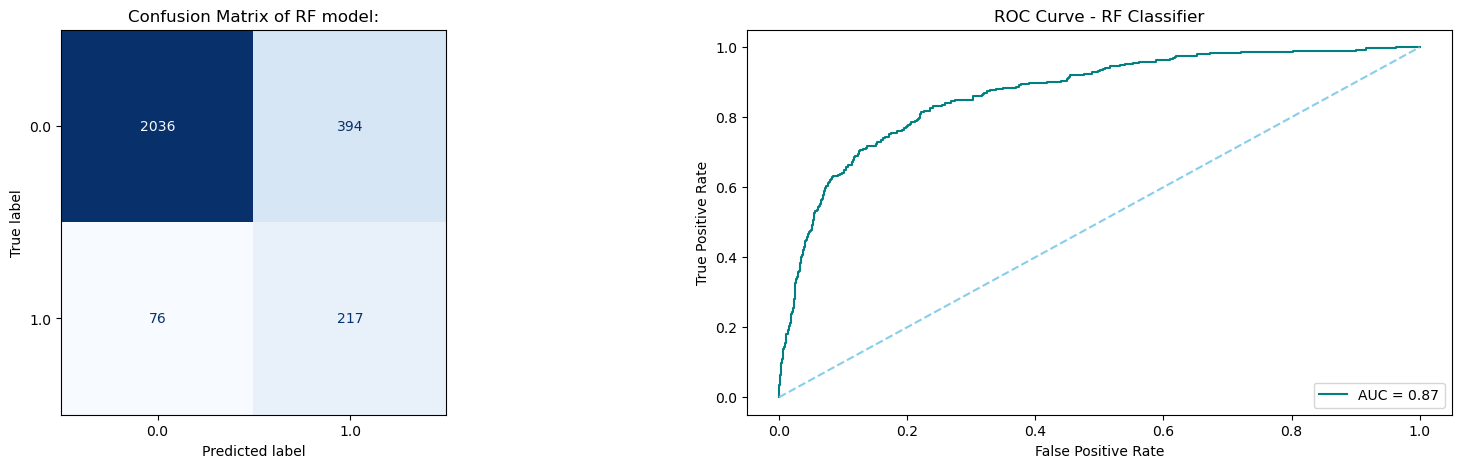

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of RF model:')
ConfusionMatrixDisplay.from_predictions(Y_test, ypred, colorbar=False, cmap='Blues', ax=ax[0])
ax[0].grid(False)


# Compute ROC metrics:
fpr, tpr, thresholds = roc_curve(Y_test.values, y_pred_score)
roc_auc = auc(fpr, tpr)
                         
ax[1].set_title('ROC Curve - RF Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, c='teal')
ax[1].plot([0,1],[0,1],'--', c='skyblue')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

In [116]:
from sklearn.metrics import precision_recall_curve

y_train_scores = make_pipe_lr.predict_proba(X_train)[:,1]

precisions, recalls, thresholds = precision_recall_curve(Y_train, y_train_scores)

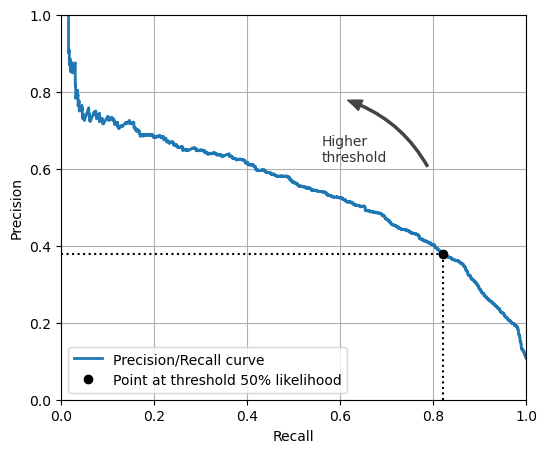

In [125]:
import matplotlib.patches as patches  # extra code – for the curved arrow


idx = (thresholds >= 0.5).argmax()


plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 50% likelihood")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [126]:
fpr, tpr, thresholds_roc = roc_curve(Y_train, y_train_scores)

areaUnderROC = auc(fpr, tpr)

# To find the best threshold we can use Youden's statistic 
# J = Sensitivity + Specificity – 1
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic

# But we have that Sensitivity is the True Positive Rate
# And then J = Sensitivity + (1 – FalsePositiveRate) – 1
# Then

J = tpr - fpr
optim = np.argmax(J)
best_thresh = thresholds_roc[optim]
print('Optimal Threshold=%f' % (best_thresh))

Optimal Threshold=0.427789


In [130]:
coefficients = make_pipe_lr.steps[2][1].coef_[0]

In [145]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 
                                   'Importance': np.abs(coefficients), 
                                   'Coef values': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

In [146]:
feature_importance.head()

,Feature,Importance,Coef values
11,COMPOTHX,1.876194,-1.876194
30,RMSP,1.647640,-1.647640
157,LANX,1.633819,-1.633819
99,FGASP,1.556835,1.556835
134,COW,1.472231,-1.472231


<Axes: ylabel='Feature'>

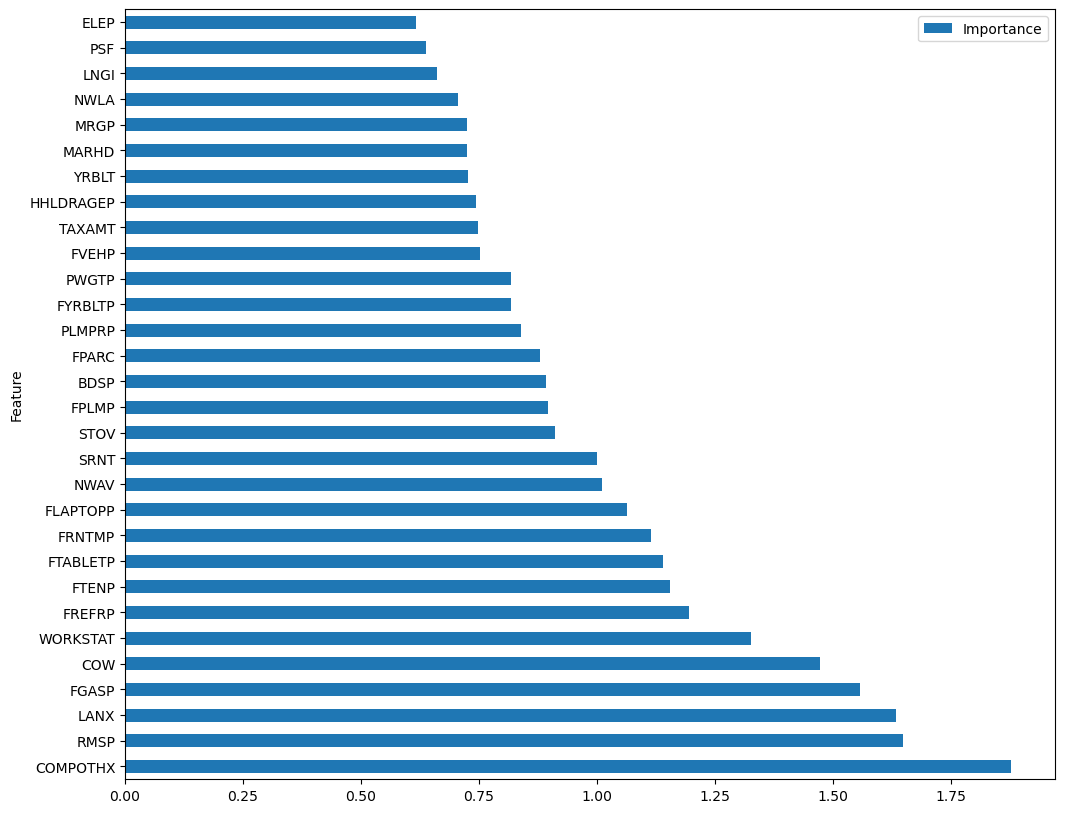

In [144]:
feature_importance.head(30).plot(x='Feature', y='Importance', kind='barh', figsize=(12, 10))

In [138]:
params = {
    'n_estimators': [50, 100, 500],
    'max_depth': [8, 10, 20, 25],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [4,6,8,10,14,20]
}

In [120]:
rfc = RandomForestClassifier(n_estimators=200, 
                             n_jobs=-1, 
                             random_state=2023)

rfc_pipeline = make_pipeline(pipeline_col, smote, rfc)

rfc_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['WGTP', 'CONP', 'ELEP', 'GASP', 'INSP', 'MRGP', 'VALP', 'WATP', 'FINCP',
       'GRPIP', 'HHLDRAGEP', 'HINCP', 'OCPIP', 'SMOCP', 'TAXAMT', 'PWGTP',
       'OIP', 'PAP', 'RETP',...
                                                                                  unknown_value=-1))]),
                                                  Index(['PUMA', 'NP', 'TYPEHUGQ', 'ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP',
       'BLD', 'BROADBND',
       ...
       'NWLA', 'NWLK', 'NWRE', 'RELSHIPP', 'SCH', 'SCHL', 'SEX', 'WKL', 'WKWN',
       'WRK'],
      dtype='object', length=162))])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=2023))])

In [121]:
cross_val_score(rfc_pipeline, X_train, Y_train, scoring='f1', cv=k5)

array([0.43708609, 0.40345821, 0.4625    , 0.48648649, 0.4875    ])

In [139]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}

In [140]:
grid_rfc = GridSearchCV(rfc_pipeline, 
                         param_grid=new_params, 
                         cv=k5, 
                         scoring='f1',
                         verbose = 1,
                         return_train_score=True)

In [141]:
grid_rfc.fit(X_train, Y_train);

# How well do we do on our validation set?
grid_rfc.best_score_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


0.5207810070525688

In [188]:
#grid_rfc.cv_results_['mean_test_score'], grid_rfc.cv_results_['mean_train_score']

In [143]:
grid_rfc.best_params_

{'randomforestclassifier__criterion': 'log_loss',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 10,
 'randomforestclassifier__n_estimators': 100}

In [137]:
grid_rfc

GridSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_imputer',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['WGTP', 'CONP', 'ELEP', 'GASP', 'INSP', 'MRGP', 'VALP', 'WATP', 'FINCP',
       'GRPI...
       'WRK'],
      dtype='object', length=162))])),
                                       ('smote',
                                        SMOTE(sampling_strategy='minority')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=2023))]),
             param_grid={'randomforestclassifier__max_depth': [4, 6, 10, 12, 20,
                                                               25],
                         'randomforestclassifier__n_estimators': [50, 100,
                                                                  500]},
             return_train_score=True, scoring='recall', verbose=1)

In [144]:
y_test_predict = grid_rfc.best_estimator_.predict(X_test)

In [145]:
recall_score(Y_test, y_test_predict)

0.5340909090909091

In [ ]:
ypred = model.predict(X_test)
print(classification_report(Y_test, ypred, labels=[0,1], target_names=['Non FS applicant [0]', 'FS Applicant [1]']))

model_comparison_evaluate(classifiers, X_train, Y_train)

y_pred_score = model.predict_proba(X_test.values)[:,1]

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of RF model:')
ConfusionMatrixDisplay.from_predictions(Y_test, ypred, colorbar=False, cmap='crest', ax=ax[0])
ax[0].grid(False)


# Compute ROC metrics:
fpr, tpr, thresholds = roc_curve(Y_test.values, y_pred_score)
roc_auc = auc(fpr, tpr)
                         
ax[1].set_title('ROC Curve - RF Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, c='teal')
ax[1].plot([0,1],[0,1],'--', c='darkseagreen')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

# Model Selection (unfinished)

In [94]:
rf = RandomForestClassifier(class_weight='balanced', 
                            random_state=2023)
n_estimators = [100, 500]
max_depth = [4, 6, 8]

rf_param = dict(n_estimators=n_estimators, 
                max_depth=max_depth)

In [97]:
rf_search = GridSearchCV(rf, 
                         rf_param, 
                         scoring='f1',
                         verbose=2,
                         n_jobs=-1)
rf_result = rf_search.fit(X_train, Y_train)


print('Best: %f using %s' % (rf_result.best_score_, rf_result.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best: 0.920991 using {'max_depth': 8, 'n_estimators': 100}


In [100]:
lr = LogisticRegression(class_weight='balanced', 
                        random_state=2023)
solver = ['liblinear']
penalty = ['l1', 'l2']
lr_param = dict(solver=solver, penalty=penalty)

In [102]:
lr_search = GridSearchCV(lr, 
                         lr_param, 
                         scoring='f1',
                         verbose=2,
                         n_jobs=-1)
lr_result = lr_search.fit(X_train, Y_train)


print('Best: %f using %s' % (lr_result.best_score_, lr_result.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best: 0.845738 using {'penalty': 'l2', 'solver': 'liblinear'}


In [98]:
xgb = XGBClassifier(random_state=2023)
max_depth = [3, 6, 9]
learning_rate = [0.1, 0.3, 0.5]
n_estimators = [100, 500]
xgb_param = dict(max_depth=max_depth, 
                 learning_rate=learning_rate, 
                 n_estimators=n_estimators)

In [99]:
xgb_search = GridSearchCV(xgb, 
                          xgb_param, 
                          scoring='f1',
                          verbose=2,
                          n_jobs=-1)

xgb_result = xgb_search.fit(X_train, Y_train)


print('Best: %f using %s' % (xgb_result.best_score_, xgb_result.best_params_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best: 0.904385 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}


In [103]:
RFParams = {'max_depth': 8, 'n_estimators': 100}
LRParams = {'penalty': 'l2', 'solver': 'liblinear'}
XGBParams = {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}


classifiers = {
                   'Random Forest Classifier':RandomForestClassifier(**RFParams, class_weight='balanced', random_state=2023),
                   'Logistic Regression': LogisticRegression(**LRParams, class_weight='balanced', random_state=2023),
                   'XGBoost Classifier' : XGBClassifier(**XGBParams,random_state=2023)
                  }

In [106]:
def model_comparison_evaluate(classifiers, X, y):
    for name, model in classifiers.items():
        f1scores = cross_val_score(model, X, y, scoring='f1', n_jobs=-1)
        rascores = cross_val_score(model, X, y, scoring='roc_auc', n_jobs=-1)
        print('{}:'.format(name))
        print('Mean F1 score using K-fold cross-validation : %.3f ± %.3f' % (f1scores.mean(), f1scores.std()))
        print('Mean ROC AUC score using K-fold cross-validation : %.3f ± %.3f\n\n' % (rascores.mean(), rascores.std()))

In [107]:
model_comparison_evaluate(classifiers, X_train, Y_train)

Random Forest Classifier:
Mean F1 score using K-fold cross-validation : 0.921 (0.063)
Mean ROC AUC score using K-fold cross-validation : 0.980 (0.022)


Logistic Regression:
Mean F1 score using K-fold cross-validation : 0.846 (0.011)
Mean ROC AUC score using K-fold cross-validation : 0.913 (0.008)


XGBoost Classifier:
Mean F1 score using K-fold cross-validation : 0.904 (0.154)
Mean ROC AUC score using K-fold cross-validation : 0.989 (0.023)




In [108]:
model = RandomForestClassifier(**RFParams, class_weight='balanced', random_state=2023)

#XGBClassifier(**XGBParams, random_state=2023)

model.fit(X_train, Y_train)
ypred = model.predict(X_test)
print(classification_report(Y_test, ypred, labels=[0,1], target_names=['Non FS applicant [0]', 'FS Applicant [1]']))

                      precision    recall  f1-score   support

Non FS applicant [0]       0.95      0.94      0.94      3645
    FS Applicant [1]       0.54      0.56      0.55       440

            accuracy                           0.90      4085
           macro avg       0.74      0.75      0.75      4085
        weighted avg       0.90      0.90      0.90      4085

[CV] END .....................max_depth=4, n_estimators=1000; total time=  23.7s
[CV] END .....................max_depth=6, n_estimators=1000; total time=  31.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=  21.5s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  45.7s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=100; total time=  44.9s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=500; total time= 3.5min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=500; total time= 4.6min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=1

/Users/anieto/opt/anaconda3/envs/text_tda/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 0, 'False Positive Rate')

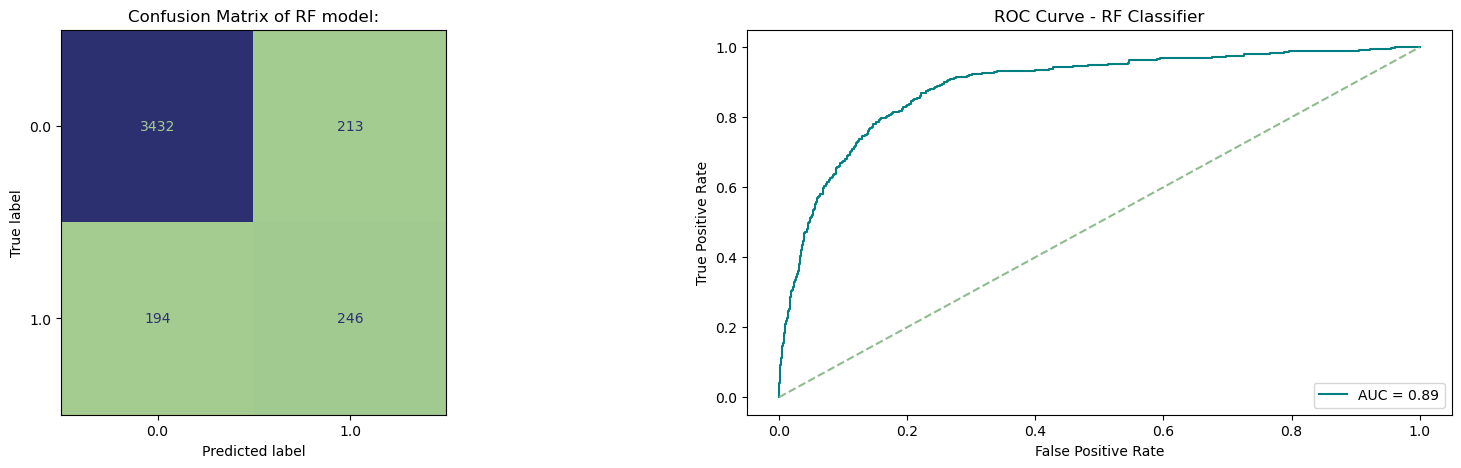

[CV] END .....................max_depth=4, n_estimators=1000; total time=  25.1s
[CV] END ......................max_depth=8, n_estimators=100; total time=   4.4s
[CV] END ......................max_depth=8, n_estimators=100; total time=   4.2s
[CV] END .....................max_depth=8, n_estimators=1000; total time=  34.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time= 1.9min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=100; total time= 1.0min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=100; total time= 1.0min
[CV] END ...learning_rate=0.1, max_depth=9, n_estimators=500; total time= 4.7min
[CV] END ...learning_rate=0.3, max_depth=6, n_estimators=500; total time= 1.9min
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time= 1.9min
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=100; total time=  20.9s
[CV] END ...learning_rate=0.5, max_depth=3, n_estimators=500; total time= 1.8min
[CV] END ...learning_rate=0.

In [109]:
y_pred_score = model.predict_proba(X_test.values)[:,1]

fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].set_title('Confusion Matrix of RF model:')
ConfusionMatrixDisplay.from_predictions(Y_test, ypred, colorbar=False, cmap='crest', ax=ax[0])
ax[0].grid(False)


# Compute ROC metrics:
fpr, tpr, thresholds = roc_curve(Y_test.values, y_pred_score)
roc_auc = auc(fpr, tpr)
                         
ax[1].set_title('ROC Curve - RF Classifier')
ax[1].plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc, c='teal')
ax[1].plot([0,1],[0,1],'--', c='darkseagreen')
ax[1].legend(loc='lower right')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')

## Missing: Feature selection using RF, Feature importance, alternative using PCA, Visualization using TDA

## Better: complete model selection, document steps and explain

# Visualization

In [190]:
import kmapper as km
from kmapper.jupyter import display
import umap
import sklearn
import sklearn.manifold as manifold
from sklearn import ensemble, cluster

In [191]:
projector = ensemble.IsolationForest(random_state=2023, 
                                     n_jobs=-1)

In [193]:
df = pipeline_col.fit_transform(data)

In [194]:
projector.fit(df)
lens1 = projector.decision_function(df)

In [195]:
mapper3 = km.KeplerMapper(verbose=3)
lens2 = mapper3.fit_transform(df, projection="knn_distance_5") # p_data en el caso anterior

lens = np.c_[lens1, lens2]

KeplerMapper(verbose=3)
..Composing projection pipeline of length 1:
	Projections: knn_distance_5
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (13615, 186)

..Projecting data using: knn_distance_5

..Scaling with: MinMaxScaler()



In [197]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [198]:
G3 = mapper.map(lens,
                df, 
                cover = km.Cover(n_cubes=20,perc_overlap=.15),
                clusterer=cluster.AgglomerativeClustering(3))

Mapping on data shaped (13615, 186) using lens shaped (13615, 2)

Creating 400 hypercubes.

Created 815 edges and 408 nodes in 0:00:01.013388.


In [202]:
data_tr = pd.DataFrame(df).T

In [204]:
data_tr.columns.to_numpy()

array([    0,     1,     2, ..., 13612, 13613, 13614])

In [205]:
_ = mapper.visualize(
    G3,
    custom_tooltips= data_tr.columns,#.to_numpy(),
    color_values=target,
    color_function_name="target",
    path_html="mapper3.html",
    #X=df,
    #X_names=df.columns.to_numpy(), #list(df[features].columns),
    lens=lens,
    lens_names=["IsolationForest", "KNN-distance 5"],
    title="Detecting GW with Isolation Forest and Nearest Neighbor Distance"
)

Wrote visualization to: mapper3.html


In [ ]:
# display mapper in jupyter
km.jupyter.display("mapper3.html")

In [210]:
p_data = mapper.fit_transform(df,
                              projection=[manifold.Isomap(n_components=20,
                                                          n_jobs=-1), umap.UMAP(n_components=2,
                                                                                random_state=2022)])

..Composing projection pipeline of length 2:
	Projections: Isomap(n_components=20, n_jobs=-1)
		UMAP(random_state=2022)
	Distance matrices: False
False
	Scalers: MinMaxScaler()
MinMaxScaler()
..Projecting on data shaped (13615, 186)

..Projecting data using: 
	Isomap(n_components=20, n_jobs=-1)



/Users/anieto/opt/anaconda3/envs/text_tda/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/anieto/opt/anaconda3/envs/text_tda/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/anieto/opt/anaconda3/envs/text_tda/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/Users/anieto/opt/anaconda3/envs/text_tda/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is e


..Scaling with: MinMaxScaler()

..Projecting on data shaped (13615, 20)

..Projecting data using: 
	UMAP(random_state=2022, verbose=1)

UMAP(random_state=2022, verbose=1)
Thu May 25 01:58:39 2023 Construct fuzzy simplicial set
Thu May 25 01:58:39 2023 Finding Nearest Neighbors
Thu May 25 01:58:39 2023 Building RP forest with 11 trees
Thu May 25 01:58:39 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu May 25 01:58:39 2023 Finished Nearest Neighbor Search
Thu May 25 01:58:39 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu May 25 01:58:49 2023 Finished embedding

..Scaling with: MinMaxScaler()



In [211]:
# cluster data using DBSCAN
G = mapper.map(p_data, 
               df, 
               nerve=km.GraphNerve(min_intersection=2),
               clusterer=sklearn.cluster.DBSCAN(eps=0.75,
                                                n_jobs = -1,
                                                metric="cosine"))

Mapping on data shaped (13615, 186) using lens shaped (13615, 2)

Creating 100 hypercubes.

Created 96 edges and 74 nodes in 0:00:01.303834.


In [ ]:
# visualize graph
mapper.visualize(G, 
                path_html="mapper_example_"+".html",
                title='GW',
                custom_tooltips = data_tr.columns,#.to_numpy(),
                color_values = target,
                color_function_name = 'Detection',
                node_color_function = np.array(['average', 'std', 'sum', 'max', 'min']))

# display mapper in jupyter
km.jupyter.display("mapper_example_"+".html")